# Customer Segmentation Analysis

## Importing the libraries

In [1]:
#libraries to use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering


## Loading data

In [2]:
#loading the dataset
data = pd.read_csv('marketing_campaign.csv', sep='\t')
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


# Data Cleaning

We will clean the data before doing any analysis to make sure it does not contain any missing values or outliers.

We will also work on the data and organise it to make it easier to analyse.

In [3]:
#information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [4]:
# Lets check the unique values in the Marital_Status column
data['Marital_Status'].unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

In [5]:
# Lets check the unique values in the Education column
data['Education'].unique()

array(['Graduation', 'PhD', 'Master', 'Basic', '2n Cycle'], dtype=object)

We can observe that

- The income column contains missing values.
- Dt_Customer column contains date values which are not in the correct format.
- The marital status column contains values can be renamed to a more appropriate name for better understanding.
- The values in education column can be renamed to reduce the number of unique values and for better understanding.
- We can combine the number of kids into a single column.
- We can combine the number of purchases into a single column.
- We can calculate the total amount spent by each customer and add it as a new column.
- We can calculate the age of the customers


In [6]:
#drop rows with missing values
data = data.dropna()

# convert Dt_Customer column to datetime with the correct format
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], format='%d-%m-%Y')

# copy the Marital_Status and Education column to a new column
data['Marital_Status2'] = data['Marital_Status']
data['Education2'] = data['Education']

# replace the values in the new column
data['Marital_Status2'] = data['Marital_Status2'].replace(['YOLO', 'Alone', 'Single', 'Absurd'], 'Single')
data['Marital_Status2'] = data['Marital_Status2'].replace(['Together'], 'Married')
data['Education2'] = data['Education2'].replace({'2n Cycle': 'Postgrad', 'Basic': 'High School', 'Graduation': 'Undergraduate', 'Master': 'Post Grad', 'PhD': 'Post Grad'})

#create a column for total number of children
data['Total_Children'] = data['Kidhome'] + data['Teenhome']

#create a column for total number of purchases
data['Total_Purchases'] = data['NumWebPurchases'] + data['NumCatalogPurchases'] + data['NumStorePurchases']

#create a column for total amount spent
data['Total_Amount_Spent'] = data['MntWines'] + data['MntFruits'] + data['MntMeatProducts'] + data['MntFishProducts'] + data['MntSweetProducts'] + data['MntGoldProds']

#age of the customer
data['Age'] = 2023 - data['Year_Birth']

#drop the columns we don't need
data = data.drop(['Year_Birth', 'Kidhome', 'Teenhome', 'NumWebPurchases', 'NumCatalogPurchases', 
                  'NumStorePurchases', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 
                  'MntGoldProds', "Z_CostContact", "Z_Revenue", 'Marital_Status', 'Education','AcceptedCmp3', 'AcceptedCmp4', 
                  'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response',], axis=1)


In [7]:
#check the new dataset
data.head()

,ID,Income,Dt_Customer,Recency,NumDealsPurchases,NumWebVisitsMonth,Marital_Status2,Education2,Total_Children,Total_Purchases,Total_Amount_Spent,Age
0,5524,58138.0,2012-09-04,58,3,7,Single,Undergraduate,0,22,1617,66
1,2174,46344.0,2014-03-08,38,2,5,Single,Undergraduate,2,4,27,69
2,4141,71613.0,2013-08-21,26,1,4,Married,Undergraduate,0,20,776,58
3,6182,26646.0,2014-02-10,26,2,6,Married,Undergraduate,1,6,53,39
4,5324,58293.0,2014-01-19,94,5,5,Married,Post Grad,1,14,422,42


We will check for outliers in the numerical columns.

In [8]:
#plot boxplots for the numerical columns to check for outliers
numeric_columns = data.select_dtypes(include=['number']).columns

def outliers_boxplots(df, columns=numeric_columns, title="Outliers", color= "magenta"):
    fig = make_subplots(rows=1, cols=len(columns))
    for i, column in enumerate(columns):
        trace = go.Box(y=df[column],name=f'{column}',marker=dict(color=color))
        fig.add_trace(trace, row=1, col=i+1)
    fig.update_layout(title_text=title, title_x=0.5)
    fig.show()

outliers_boxplots(data, numeric_columns)

We have some outliers in the the income and age columns. We will remove them.

In [9]:
#remove outliers
data = data[data['Income'] < 150000]
data = data[data['Age'] < 80]

In [10]:
#check the new dataset
outliers_boxplots(data, numeric_columns)

# Data Processing

## Scaling the data

We will scale the data to make sure all the features are in the same range.

In [11]:
data_cluster = data[['Income', 'Recency', 'Total_Children', 'Total_Purchases', 'Total_Amount_Spent', 'Age']]

#scaling the data into pandas dataframe
scaler = StandardScaler()
scaler.fit(data_cluster)
scaled_data = pd.DataFrame(scaler.transform(data_cluster), columns=data_cluster.columns)

#check the new dataset
scaled_data.head()


,Income,Recency,Total_Children,Total_Purchases,Total_Amount_Spent,Age
0,0.316925,0.312754,-1.272616,1.318365,1.684321,1.033311
1,-0.252537,-0.378166,1.400364,-1.191434,-0.961803,1.291619
2,0.967553,-0.792719,-1.272616,1.039498,0.284704,0.344489
3,-1.203637,-0.792719,0.063874,-0.912568,-0.918533,-1.291463
4,0.324409,1.556410,0.063874,0.202899,-0.304433,-1.033154


## Principal Component Analysis
This is done to reduce the number of features and to make it easier to visualise the clusters and minimise the loss of information.

In [12]:
#PCA to reduce the dimensionality of the dataset
pca = PCA(n_components=3)
pca.fit(scaled_data)
PCA_df = pd.DataFrame(pca.transform(scaled_data), columns=['PCA1', 'PCA2', 'PCA3'])
PCA_df.head()

,PCA1,PCA2,PCA3
0,2.360227,0.323268,0.210500
1,-1.623498,1.648905,-0.687147
2,1.692784,-0.331669,-0.798281
3,-1.813519,-1.345355,-0.535588
4,-0.024082,-0.477067,1.694824


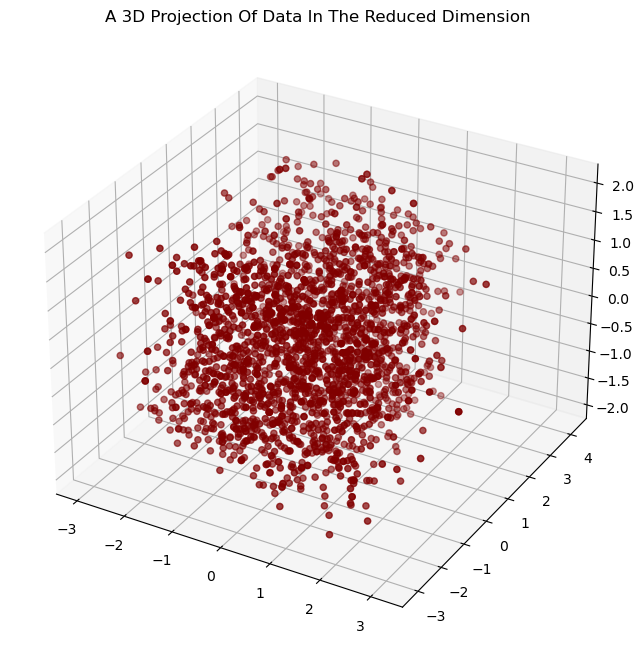

In [13]:
#A 3D Projection Of Data In The Reduced Dimension
y =PCA_df["PCA1"]
x =PCA_df["PCA2"]
z =PCA_df["PCA3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

#  Clustering

## Elbow Method
We will use the elbow method to find the optimal number of clusters.

c:\ProgramData\Anaconda3\envs\geo_env\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\ProgramData\Anaconda3\envs\geo_env\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\ProgramData\Anaconda3\envs\geo_env\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\ProgramData\Anaconda3\envs\geo_env\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\ProgramData\Anaconda3\envs\geo_env\Lib\site-packages\sklearn\

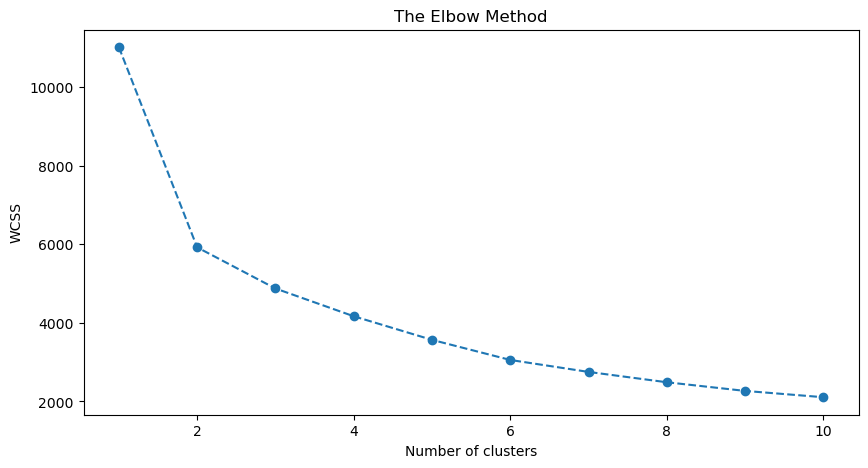

In [14]:
#elbow method
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(PCA_df)
    wcss.append(kmeans.inertia_)

#plot the elbow method
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

## Agglomerative Clustering
This is a hierarchical clustering method. We will use this to find the clusters.

In [15]:
#Agglomerative Clustering model
AC = AgglomerativeClustering(n_clusters=3)

#fit the model
AC_df = AC.fit_predict(PCA_df)
PCA_df['Cluster'] = AC_df

#add cluster column to the original dataset
data['Cluster'] = AC_df


In [16]:
PCA_df.head()

,PCA1,PCA2,PCA3,Cluster
0,2.360227,0.323268,0.210500,2
1,-1.623498,1.648905,-0.687147,0
2,1.692784,-0.331669,-0.798281,2
3,-1.813519,-1.345355,-0.535588,0
4,-0.024082,-0.477067,1.694824,0


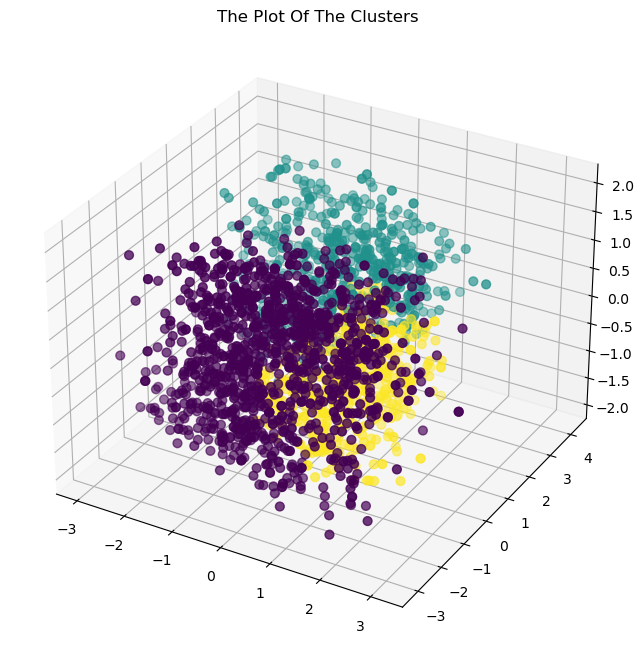

In [17]:
#plot the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_df["Cluster"], marker='o')
ax.set_title("The Plot Of The Clusters")
plt.show()

Let's check the number of customers in each cluster.

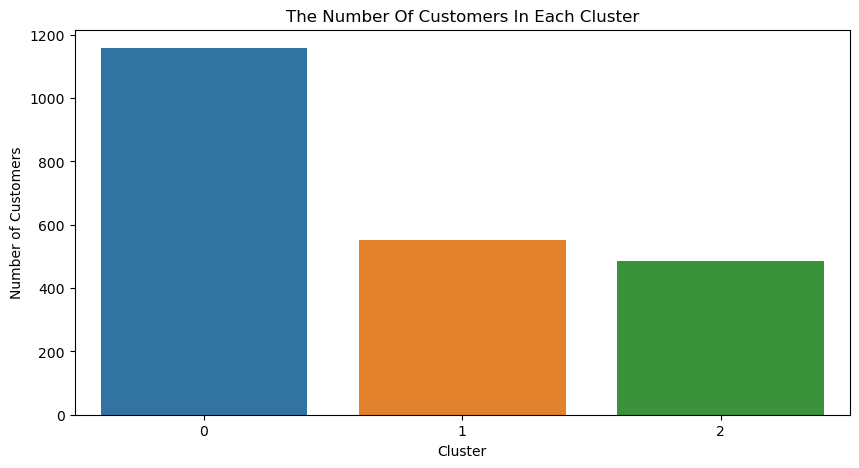

In [18]:
#plot the number of customers in each cluster
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='Cluster')
plt.title('The Number Of Customers In Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()

The clusters are fairly balanced.

Let's visualise the data with the clusters.

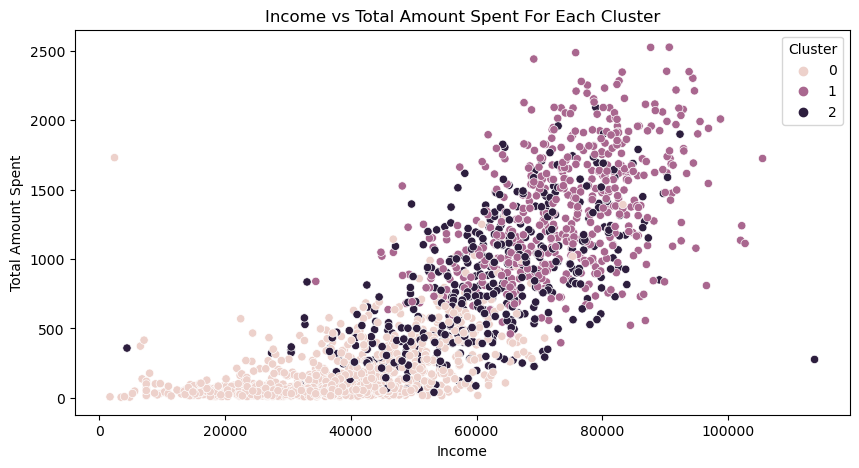

In [19]:
#plot income vs total amount spent for each cluster
plt.figure(figsize=(10, 5))
sns.scatterplot(data=data, x='Income', y='Total_Amount_Spent', hue='Cluster')
plt.title('Income vs Total Amount Spent For Each Cluster')
plt.xlabel('Income')
plt.ylabel('Total Amount Spent')
plt.show()

Spendings vs Income Plot shows
- Cluster 0: Low Income, Low Spendings
- Cluster 1: High Income, High Spendings
- Cluster 2: Medium Income, Low, Medium and High Spendings

Let's check the clusters with the all the numerical features.

In [21]:
# Create a subplot grid
columns = ["Income", "Age", "Recency"]

fig = make_subplots(rows=1, cols=3, subplot_titles=[f'Cluster vs. {column}' for column in columns], horizontal_spacing=0.15)

for i, column in enumerate(columns):
    row = i // 3 + 1
    col = i % 3 + 1
    
    # Create a box plot for each column
    trace = go.Box(y=data[column], x=data["Cluster"], name=f'Cluster vs. {column}', )
    fig.add_trace(trace, row=row, col=col)

# Update layout
fig.update_layout(
    showlegend=False,
    height=800,
    title_text="Cluster vs. Numeric Columns",
)

# Show the plot
fig.show()

In [22]:
#plot education for each cluster
fig = px.histogram(data, x="Marital_Status2", color="Cluster", title="Education For Each Cluster", barmode="group")
fig.show()

In [23]:
#plot education for each cluster
fig = px.histogram(data, x="Education2", color="Cluster", title="Education For Each Cluster", barmode="group")
fig.show()

In [24]:
#plot total children for each cluster
fig = px.histogram(data, x="Total_Children", color="Cluster", title="Total Children For Each Cluster", barmode="group")
fig.show()

# Conclusion

We can observe the following attributes for each segmented cluster.
Cluster 0
- Earns the average least income of 36k being the lowest
- Average age is 50
- Average Spending habits with average recency of 55 days
- Mostly married
- Mostly educated with high numbers of undergraduates and postgraduates
- Mostly has 1 child

Cluster 1
- Earns the average highest income of 74k being the highest
- Average age is 52
- Lower spending habits with average recency of 66 days
- Mostly married but significantly less than cluster 0
- Mostly educated with high numbers of undergraduates and postgraduates
- Mostly has no child

Cluster 2
- Earns the average medium income of 61k 
- Average age is 62
- High spending habits with average recency of 23 days
- Mostly married but slightly less than cluster 1
- Mostly educated with average numbers of undergraduates and postgraduates
- Mostly has 1 child
